The Particle in Cell Method: Exploring Plasma Simulators using Leapfrog or Runge-Kutta Integration and Bi-linear or Linear Interpolation
Sneha Nair: Computational Method Final Project


# 1D Particle-in-Cell Simulation for Two-Stream Instability

This notebook cell is responsible for simulating the **Two-Stream Instability** using a 1D **Particle-in-Cell (PIC)** approach. The simulation models the interaction between two counter-streaming particle beams under the influence of an electric field. This serves as an introductory exercise into PIC simulations. Users can experiment with various parameters, including the number of particles, perturbation types, and integration methods.

---

### Simulation Parameters
- **Number of Particles:** `num_particles` = 40,000
- **Number of Mesh Cells:** `num_mesh_cells` = 400
- **Simulation End Time:** `simulation_end_time` = 50
- **Timestep:** `time_step` = 1
- **Domain Size:** `domain_size` = 50 (periodic boundary)
- **Electron Density:** `electron_density` = 1
- **Beam Velocity:** `beam_velocity` = 3
- **Beam Width:** `beam_width` = 1
- **Perturbation Amplitude:** `perturbation_amplitude` = 0.1

---

### Equations Used

1. **Equation of Motion**:
   \[
   \frac{d^2x}{dt^2} = qE
   \]
   Here, \( q \) is the charge, \( E \) is the electric field, and \( x \) is the position.

2. **Poisson's Equation**:
   \[
   \nabla^2\phi = \frac{\rho - \rho_0}{\epsilon_0}
   \]
   \(\phi\) is the potential, \(\rho\) is the charge density, and \(\rho_0\) is the background density.

3. **Electric Field**:
   \[
   E = -\nabla\phi
   \]

---

### Perturbation Types
The initial velocity distribution of particles can be perturbed using different methods:
- **Sinusoidal Perturbation**: 
  \[
  v_i = v_i \cdot \left(1 + A \sin\left(\frac{2\pi x_i}{L}\right)\right)
  \]
- **Cosine Perturbation**:
  \[
  v_i = v_i \cdot \left(1 + A \cos\left(\frac{2\pi x_i}{L}\right)\right)
  \]
- **Gaussian Perturbation**:
  \[
  v_i = v_i \cdot \left(1 + A \exp\left(-\frac{(x_i - x_c)^2}{2\sigma^2}\right)\right)
  \]
- **Random Noise**:
  \[
  v_i = v_i \cdot \left(1 + A \cdot \text{rand}(-1, 1)\right)
  \]

---

### Simulation Workflow

1. **Initialization**:
   - Particles are initialized with random positions and Gaussian-distributed velocities.
   - Opposite particle beams (\(+v\) and \(-v\)) are created for instability analysis.

2. **Electric Field Calculation**:
   - Poisson's equation is solved using a finite-difference approach to compute the electric field on a grid.

3. **Integration Methods**:
   - **Leapfrog**: Symplectic integrator for efficient simulation.
   - **Runge-Kutta 4th Order**: Higher-order accuracy for comparison.

4. **Visualization**:
   - **Phase Space Diagram**: Position vs. Velocity for both beams.
   - **Charge Density**: Particle density on the grid.
   - **Electric Field**: Field intensity across the domain.

---

### Schematic Representation

Below is a conceptual schematic of the simulation setup (source: https://boltzplatz.eu/intro-particle-in-cell/):
![FlowChart](scheme.jpg)

In [30]:
'''
These are all of the necessary import statements needed to run the code. This block of code must be run everytime before starting the
notebook.
'''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation, PillowWriter
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import matplotlib.animation as animation
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter

MovieWriter imagemagick unavailable; using Pillow instead.


Saved simulation as GIF: .//simulation.gif


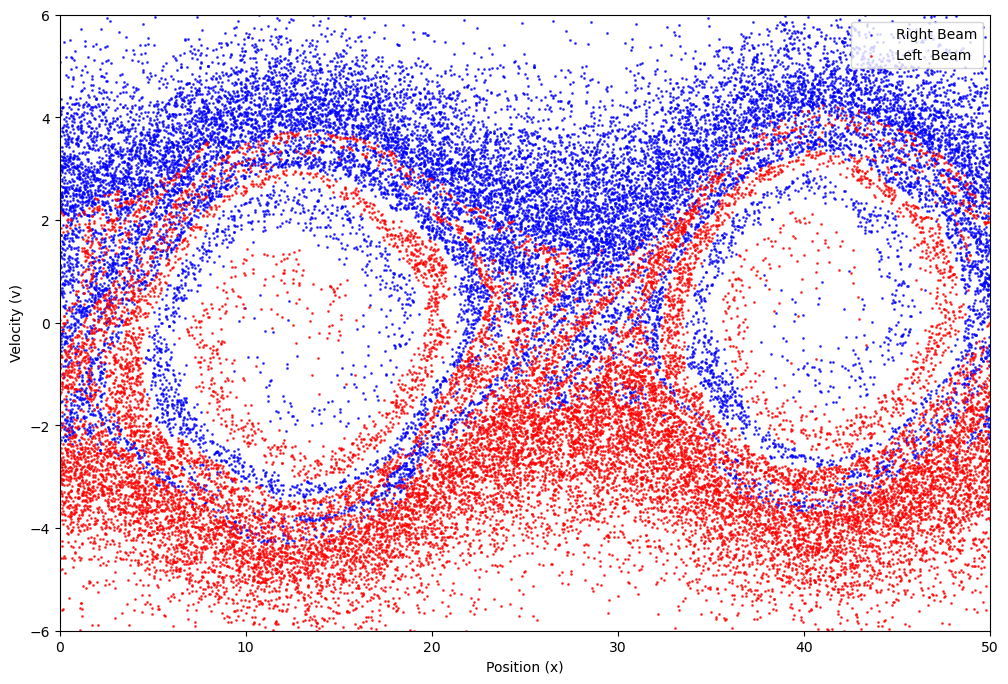

MovieWriter imagemagick unavailable; using Pillow instead.


Saved simulation as GIF: .//simulation.gif


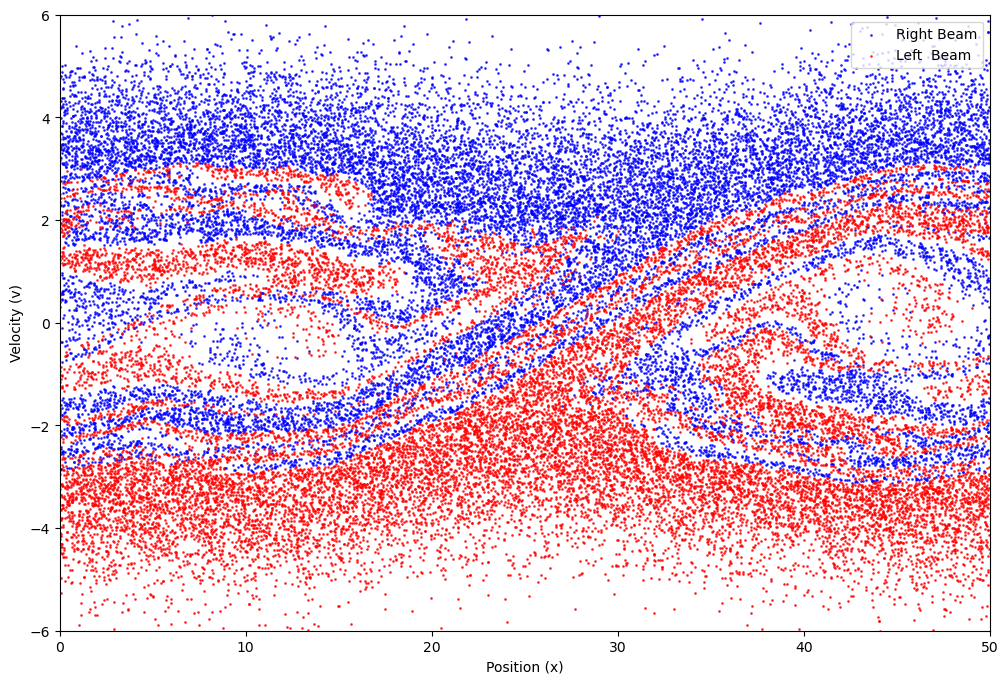

In [5]:
'''
This cell is responsible for all the calculation relevant to the 1D Portion of Our Simulation, where we will investigate the
Two Stream Instability Problem as a rudimentary excerise into the PIC world. Please feel free to play around with the number of particles.
'''

# Simulation parameters
num_particles=40000          # Number of particles
num_mesh_cells=400           # Number of mesh cells
simulation_end_time=50       # Time at which simulation ends
time_step=1                  # Timestep
domain_size=50               # Periodic domain [0, domain_size]
electron_density=1           # Electron number density
beam_velocity=3              # Beam velocity
beam_width=1                 # Beam width
perturbation_amplitude=0.1   # Perturbation

def initial_conditions(num_particles, domain_size, beam_width, beam_velocity, perturbation_type="sinusoidal"):
    np.random.seed(42)
    positions = np.random.rand(num_particles, 1) * domain_size
    velocities = beam_width * np.random.randn(num_particles, 1) + beam_velocity
    half_particles = int(num_particles / 2)
    velocities[half_particles:] *= -1

    if perturbation_type == "sinusoidal":
        velocities *= (1 + perturbation_amplitude * np.sin(2 * np.pi * positions / domain_size))
    elif perturbation_type == "cosine":
        velocities *= (1 + perturbation_amplitude * np.cos(2 * np.pi * positions / domain_size))
    elif perturbation_type == "gaussian":
        gaussian_center = domain_size / 2
        gaussian_width = domain_size / 10
        velocities *= (1 + perturbation_amplitude * np.exp(-((positions - gaussian_center)**2) / (2 * gaussian_width**2)))
    elif perturbation_type == "random_noise":
        velocities *= (1 + perturbation_amplitude * np.random.uniform(-1, 1, size=velocities.shape))

    return velocities, positions, half_particles

def construct_gradient_matrix(domain_size, num_mesh_cells):
    cell_size = domain_size / num_mesh_cells
    ones_vector = np.ones(num_mesh_cells)
    diagonals = np.array([-1, 1])
    values = np.vstack((-ones_vector, ones_vector))
    gradient_matrix = sp.spdiags(values, diagonals, num_mesh_cells, num_mesh_cells)
    gradient_matrix = sp.lil_matrix(gradient_matrix)
    gradient_matrix[0, num_mesh_cells - 1] = -1
    gradient_matrix[num_mesh_cells - 1, 0] = 1
    gradient_matrix /= (2 * cell_size)
    return sp.csr_matrix(gradient_matrix)

def construct_laplacian_matrix(domain_size, num_mesh_cells):
    cell_size = domain_size / num_mesh_cells
    ones_vector = np.ones(num_mesh_cells)
    diagonals = np.array([-1, 0, 1])
    values = np.vstack((ones_vector, -2 * ones_vector, ones_vector))
    laplacian_matrix = sp.spdiags(values, diagonals, num_mesh_cells, num_mesh_cells)
    laplacian_matrix = sp.lil_matrix(laplacian_matrix)
    laplacian_matrix[0, num_mesh_cells - 1] = 1
    laplacian_matrix[num_mesh_cells - 1, 0] = 1
    laplacian_matrix /= cell_size**2
    return sp.csr_matrix(laplacian_matrix)

def calculate_acceleration(positions, num_mesh_cells, domain_size, electron_density, gradient_matrix, laplacian_matrix):
    num_particles = positions.shape[0]
    cell_size = domain_size / num_mesh_cells

    indices = np.floor(positions / cell_size).astype(int)
    next_indices = indices + 1
    weight_indices = (next_indices * cell_size - positions) / cell_size
    weight_next_indices = (positions - indices * cell_size) / cell_size
    next_indices = np.mod(next_indices, num_mesh_cells)  # Periodic BC
    charge_density = np.bincount(indices[:, 0], weights=weight_indices[:, 0], minlength=num_mesh_cells)
    charge_density += np.bincount(next_indices[:, 0], weights=weight_next_indices[:, 0], minlength=num_mesh_cells)
    charge_density *= electron_density * domain_size / num_particles / cell_size

    potential = spsolve(laplacian_matrix, charge_density - electron_density, permc_spec="MMD_AT_PLUS_A")
    electric_field = -gradient_matrix @ potential
    field_at_positions = weight_indices * electric_field[indices] + weight_next_indices * electric_field[next_indices]

    return -field_at_positions

def leapfrog(positions, velocities, accelerations, time_step, domain_size, num_mesh_cells, electron_density, gradient_matrix, laplacian_matrix):
    positions += velocities * time_step + 0.5 * accelerations * time_step**2
    positions %= domain_size  # Apply periodic boundary conditions
    new_accelerations = calculate_acceleration(positions, num_mesh_cells, domain_size, electron_density, gradient_matrix, laplacian_matrix)
    velocities += 0.5 * (accelerations + new_accelerations) * time_step
    return positions, velocities, new_accelerations

def runge_kutta_4(positions, velocities, time_step, domain_size, num_mesh_cells, electron_density, gradient_matrix, laplacian_matrix):
    """
    Fourth-order Runge-Kutta integration for updating positions and velocities.
    """
    def compute_accel(pos):
        return calculate_acceleration(pos, num_mesh_cells, domain_size, electron_density, gradient_matrix, laplacian_matrix)

    # Stage 1
    k1_v = velocities
    k1_a = compute_accel(positions)

    # Stage 2
    k2_v = velocities + 0.5 * k1_a * time_step
    k2_pos = (positions + 0.5 * k1_v * time_step) % domain_size  # Apply periodic boundary conditions
    k2_a = compute_accel(k2_pos)

    # Stage 3
    k3_v = velocities + 0.5 * k2_a * time_step
    k3_pos = (positions + 0.5 * k2_v * time_step) % domain_size  # Apply periodic boundary conditions
    k3_a = compute_accel(k3_pos)

    # Stage 4
    k4_v = velocities + k3_a * time_step
    k4_pos = (positions + k3_v * time_step) % domain_size  # Apply periodic boundary conditions
    k4_a = compute_accel(k4_pos)

    # Update velocities and positions
    velocities += (time_step / 6) * (k1_a + 2 * k2_a + 2 * k3_a + k4_a)
    positions = (positions + (time_step / 6) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)) % domain_size  # Periodic boundary

    return positions, velocities

def run_simulation_1d(method="leapfrog",perturbation_type= "sinusoidal", save_gif=False, gif_name="simulation.gif", gif_path="./", visualization_mode="Phase Space"):
    velocities, positions, half_particles = initial_conditions(num_particles, domain_size, beam_width, beam_velocity,perturbation_type)
    gradient_matrix = construct_gradient_matrix(domain_size, num_mesh_cells)
    laplacian_matrix = construct_laplacian_matrix(domain_size, num_mesh_cells)
    acceleration = calculate_acceleration(positions, num_mesh_cells, domain_size, electron_density, gradient_matrix, laplacian_matrix)
    num_timesteps = int(np.ceil(simulation_end_time / time_step))
    current_time = 0

    # Set up the figure for plotting
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    if visualization_mode == "Phase Space":
        scatter_front = ax.scatter([], [], s=1, color="blue", alpha=0.7,label='Right Beam')
        scatter_back = ax.scatter([], [], s=1, color="red", alpha=0.7,label = 'Left  Beam')
        ax.set_xlim(0, domain_size)
        ax.set_ylim(-6, 6)
        ax.set_xlabel("Position (x)")
        ax.set_ylabel("Velocity (v)")
        ax.legend(loc="upper right")
    else:
        if visualization_mode =="Phase Space":
            line, = ax.plot([], [], color="blue")
        else:
            line, = ax.plot([], [], label=visualization_mode, color="blue")
        ax.set_xlim(0, domain_size)
        ax.set_ylim(-5, 5)  # Dynamically adjusted
        ax.set_xlabel("Position (x)")
        ax.set_ylabel(visualization_mode)
        ax.legend(loc="upper right")

    def update(frame):
        nonlocal positions, velocities, acceleration, current_time
    
        if method == "leapfrog":
            positions, velocities, acceleration = leapfrog(
                positions, velocities, acceleration, time_step, domain_size, num_mesh_cells, electron_density, gradient_matrix, laplacian_matrix
            )
        elif method == "runge_kutta":
            positions, velocities = runge_kutta_4(
                positions, velocities, time_step, domain_size, num_mesh_cells, electron_density, gradient_matrix, laplacian_matrix
            )
            # Recalculate acceleration after RK4 step for consistency
            acceleration = calculate_acceleration(positions, num_mesh_cells, domain_size, electron_density, gradient_matrix, laplacian_matrix)
        else:
            raise ValueError("Unknown integration method. Use 'leapfrog' or 'runge_kutta'.")
        current_time += time_step

        charge_density = np.bincount(
            np.floor(positions[:, 0] * num_mesh_cells / domain_size).astype(int),
            minlength=num_mesh_cells
        )
        electric_field = -gradient_matrix @ spsolve(laplacian_matrix, charge_density - electron_density)

        if visualization_mode == "Phase Space":
            scatter_front.set_offsets(np.column_stack((positions[:half_particles], velocities[:half_particles])))
            scatter_back.set_offsets(np.column_stack((positions[half_particles:], velocities[half_particles:])))
            return scatter_front, scatter_back
        elif visualization_mode == "Charge Density":
            line.set_data(np.linspace(0, domain_size, num_mesh_cells), charge_density)
            ax.set_ylim(0, max(charge_density) * 1.1)
            return line,
        elif visualization_mode == "Electric Field":
            line.set_data(np.linspace(0, domain_size, num_mesh_cells), electric_field)
            ax.set_ylim(min(electric_field) * 1.1, max(electric_field) * 1.1)
            return line,

    ani = animation.FuncAnimation(fig, update, frames=num_timesteps, interval=50, blit=True)

    if save_gif:
        ani.save(f"{gif_path}/{gif_name}", writer="imagemagick", fps=20)
        print(f"Saved simulation as GIF: {gif_path}/{gif_name}")

    plt.show()

# Example usage
run_simulation_1d(method="leapfrog", perturbation_type="random_noise",save_gif=True, visualization_mode="Phase Space")
run_simulation_1d(method="runge_kutta",perturbation_type="cos", save_gif=True, visualization_mode="Phase Space")


# 2D Particle-In-Cell (PIC) Simulation Code

Welcome to the **2D Particle-In-Cell (PIC) Simulation**! This code is designed to simulate particle interactions and charge dynamics in a 2D grid using the Particle-In-Cell method. It includes features for initializing particles, injecting dense particle blocks, handling shocks, and visualizing charge density and particle dynamics.

---

## **Key Features**

### Particle Initialization
- **Random Initialization**: Distributes particles uniformly across the simulation domain.
- **Dense Block Injection**: Allows the injection of particles in a specific region with controlled velocity spreads.

### Simulation Methods
- **Leapfrog Integration**: Efficient method for updating particle positions and velocities.
- **Runge-Kutta Integration**: Higher-order integration for more accurate particle trajectory calculations.

### Boundary Conditions
- **Periodic**: Particles leaving one side of the domain re-enter on the opposite side.
- **Sticky**: Particles stick to boundaries upon contact.
- **Reflective**: Particles bounce back when hitting a boundary.

### Shock Simulation
- **Shock Front**: Models a moving shock front with particles reflecting upon contact.
- **Shock Block**: Applies a dense block of particles with size of your choosing and density of your choosing.

### Visualization
- Real-time density plots using a log scale to highlight regions of high and low charge density.
- Scatter plots for particle positions to observe their movement.

---

## **Code Functions Overview**

### Initialization
- `initialize_particles(num_particles, lx, ly)`: Sets up particle positions and velocities within the simulation domain.
- `inject_particles_block_with_spread(particles, block_params, num_dense_particles, mean_velocity, spread)`: Adds particles to a specific block with velocity spread.

### Shock Features
- `initialize_shock_particles()`: Creates shock particles.
- `update_shock_particles()`: Moves shock particles to simulate a traveling front.
- `apply_shock_reflection()`: Reflects particles interacting with the shock.
- `apply_shock_force()`: Applies forces on particles near the shock.

### Acceleration and Integration
- `calculate_acceleration()`: Computes particle acceleration due to electric fields.
- `leapfrog_step()`: Updates particle dynamics using the Leapfrog method.
- `runge_kutta_step()`: Updates particle dynamics using the Runge-Kutta method.

### Boundary Conditions
- `apply_periodic_boundary()`: Implements periodic boundaries.
- `apply_sticky_boundary()`: Prevents particles from leaving the domain.
- `apply_reflective_boundary()`: Reflects particles at boundaries.

### Visualization
- Interactive density and position plotting with Matplotlib.
- Option to save the simulation as an animated GIF.

---

## **How to Use**
1. **Set Parameters**: Adjust domain size, particle count, and simulation time steps in the `run_simulation_2d()` function.
2. **Choose a Method**:
   - `"block"` for particle block injection.
   - `"front"` for shock simulation.
3. **Select Integration Method**:
   - `"leapfrog"` for faster but slightly less accurate integration.
   - `"runge_kutta"` for higher accuracy.
4. **Pick Boundary Type**:
   - `"periodic"`, `"sticky"`, or `"reflective"`.
5. **Run the Simulation**: Call the `run_simulation_2d()` function with the chosen options.

---

## **Example**
To simulate particle block injection using Leapfrog integration and periodic boundaries:

run_simulation_2d(method="block", integration_method="leapfrog", boundary_type="periodic")


To simulate shock front injection using Runge Kutta integration and reflective boundaries:

run_simulation_2d(method="front", integration_method="runge_kutta", boundary_type="reflective")



In [58]:
# --- Helper Functions ---
def initialize_particles(num_particles, lx, ly):
    """
    Initialize particle positions and velocities.
    """
    return {"x": np.random.uniform(0, lx, num_particles),"y": np.random.uniform(0, ly, num_particles),
            "vx": np.zeros(num_particles),"vy": np.zeros(num_particles),}


def inject_particles_block_with_spread(particles, block_params, num_dense_particles, mean_velocity, spread):
    """
    Inject dense particles into the specified block region with a velocity spread.
    """
    x_min, x_max, y_min, y_max = block_params
    dense_particles_x = np.random.uniform(x_min, x_max, num_dense_particles)
    dense_particles_y = np.random.uniform(y_min, y_max, num_dense_particles)
    dense_particles_vx = np.random.normal(mean_velocity[0], spread, num_dense_particles)
    dense_particles_vy = np.random.normal(mean_velocity[1], spread, num_dense_particles)

    particles["x"] = np.concatenate((particles["x"], dense_particles_x))
    particles["y"] = np.concatenate((particles["y"], dense_particles_y))
    particles["vx"] = np.concatenate((particles["vx"], dense_particles_vx))
    particles["vy"] = np.concatenate((particles["vy"], dense_particles_vy))

def initialize_shock_particles(shock_x, shock_width, ly, num_shock_particles, shock_velocity):
    """
    Initialize shock particles with fixed positions and velocities.
    """
    shock_particles_x = np.linspace(shock_x, shock_x + shock_width, num_shock_particles)
    shock_particles_y = np.random.uniform(0, ly, num_shock_particles)
    shock_particles_vx = np.full(num_shock_particles, shock_velocity)
    shock_particles_vy = np.zeros(num_shock_particles)
    
    return {
        "x": shock_particles_x,"y": shock_particles_y,
        "vx": shock_particles_vx,"vy": shock_particles_vy,}

# --- Boundary Condition Functions ---
def apply_periodic_boundary(particles, lx, ly):

    '''
    Most basic form of boundary condition.
    '''
    particles["x"] %= lx
    particles["y"] %= ly


def apply_sticky_boundary(particles, lx, ly):

    '''
    In case you want it to stick to any boundary like a plasma in a metal.
    '''
    particles["x"][particles["x"] < 0] = 0
    particles["vx"][particles["x"] < 0] = 0

    particles["x"][particles["x"] > lx] = lx
    particles["vx"][particles["x"] > lx] = 0

    particles["y"][particles["y"] < 0] = 0
    particles["vy"][particles["y"] < 0] = 0

    particles["y"][particles["y"] > ly] = ly
    particles["vy"][particles["y"] > ly] = 0

def apply_reflective_boundary(particles, lx, ly):
    """
    Reflect particles off the walls of the domain at all fronts!
    """
    # Reflect x-boundary
    left_boundary = particles["x"] < 0
    right_boundary = particles["x"] > lx
    particles["vx"][left_boundary | right_boundary] *= -1
    particles["x"][left_boundary] = -particles["x"][left_boundary]
    particles["x"][right_boundary] = 2 * lx - particles["x"][right_boundary]

    # Reflect y-boundary
    bottom_boundary = particles["y"] < 0
    top_boundary = particles["y"] > ly
    particles["vy"][bottom_boundary | top_boundary] *= -1
    particles["y"][bottom_boundary] = -particles["y"][bottom_boundary]
    particles["y"][top_boundary] = 2 * ly - particles["y"][top_boundary]

def boundary_handler(particles, lx, ly, boundary_type):
    """
    Handle boundary conditions dynamically based on the type choosen by the user below!
    """
    if boundary_type == "sticky":
        apply_sticky_boundary(particles, lx, ly)
    elif boundary_type == "periodic":
        apply_periodic_boundary(particles, lx, ly)
    elif boundary_type == "reflective":
        apply_reflective_boundary(particles, lx, ly)
    else:
        raise ValueError(f"Unknown boundary type: {boundary_type}")


def update_shock_particles(shock_particles, shock_velocity, dt, lx):
    """
    Update the positions of the shock particles to simulate a moving shock front.
    """
    shock_particles["x"] += shock_velocity * dt
    shock_particles["x"] %= lx  # Apply periodic boundary conditions

def apply_shock_reflection(particles, shock_particles, shock_x, shock_width):
    """
    Reflect particles that interact with the shock front.
    """
    in_shock_range = (shock_x <= particles["x"]) & (particles["x"] <= shock_x + shock_width)
    particles["vx"][in_shock_range] = -abs(particles["vx"][in_shock_range])

def apply_shock_force(particles, shock_x, shock_width, strength):
    """
    Apply a force to particles ahead of the shock front!
    """
    distance = np.maximum(0, shock_x - particles["x"])
    in_shock_effect = distance <= shock_width
    particles["vx"][in_shock_effect] += strength * (shock_width - distance[in_shock_effect]) / shock_width



def construct_2d_fd_matrices(nx, ny, dx, dy):
    """
    Directly construct 2D gradient and Laplacian matrices using finite difference formulas based on the Central Differencing Method. 
    """
    N = nx * ny  # Total number of grid points
    Gx = sp.lil_matrix((N, N))
    Gy = sp.lil_matrix((N, N))
    L = sp.lil_matrix((N, N))

    for i in range(nx):
        for j in range(ny):
            idx = i + j * nx  

            # Gradient in x-direction
            Gx[idx, idx] = -1 / (2 * dx)
            Gx[idx, (idx + 1) % nx + j * nx] = 1 / (2 * dx) 

            # Gradient in y-direction
            Gy[idx, idx] = -1 / (2 * dy)
            Gy[idx, (idx + nx) % N] = 1 / (2 * dy)  

            # Laplacian
            L[idx, idx] = -2 / dx**2 - 2 / dy**2
            L[idx, (idx + 1) % nx + j * nx] = 1 / dx**2 
            L[idx, (idx - 1 + nx) % nx + j * nx] = 1 / dx**2  
            L[idx, (idx + nx) % N] = 1 / dy**2  
            L[idx, (idx - nx + N) % N] = 1 / dy**2  

    return Gx.tocsr(), Gy.tocsr(), L.tocsr()

def scatter_particles(particles, scatter_strength):
    """
    Apply some random perturbations to the particles to more accurately simulate collisions within the plasma!
    """
    particles["vx"] += np.random.normal(0, scatter_strength, len(particles["vx"]))
    particles["vy"] += np.random.normal(0, scatter_strength, len(particles["vy"]))

# --- Core Functions ---
def calculate_acceleration(particles, nx, ny, lx, ly, n0, charge, mass, Gx, Gy, L, boundary_type):
    """
    
    Calculate particle accelerations and grid charge density with boundary condition handling. This is the best way to handle the 
    boundary handling because alot of the methods I saw online usually update the acceleration via implicit peridoci boundayr conditions 
    so I am going to add a nice little boundary handler here. 
    
    """
    num_particles = particles['x'].size
    dx, dy = lx / nx, ly / ny
    rho_grid = np.zeros((nx, ny))

    # Bin particles to the grid
    for i in range(num_particles):
        x, y = particles['x'][i], particles['y'][i]
        i0, j0 = int(np.clip(x // dx, 0, nx - 1)), int(np.clip(y // dy, 0, ny - 1))
        i1, j1 = (i0 + 1) % nx, (j0 + 1) % ny  # Handles periodic wrapping

        # Calculate weights
        wx0, wy0 = (i1 * dx - x) / dx, (j1 * dy - y) / dy
        wx1, wy1 = 1 - wx0, 1 - wy0

        # Accumulate charge density on the grid using weighted bilear interpolation here where the weights are the same ones above.
        rho_grid[i0, j0] += wx0 * wy0
        rho_grid[i1, j0] += wx1 * wy0
        rho_grid[i0, j1] += wx0 * wy1
        rho_grid[i1, j1] += wx1 * wy1

    # Normalize charge density
    rho_grid *= charge * lx * ly / (num_particles * dx * dy)
    rho_flat = rho_grid.flatten()
    phi_flat = spsolve(L, rho_flat - n0)
    phi_grid = phi_flat.reshape((nx, ny))

    # Compute electric field from potential
    Ex_flat = -Gx @ phi_flat
    Ey_flat = -Gy @ phi_flat
    Ex_grid = Ex_flat.reshape((nx, ny))
    Ey_grid = Ey_flat.reshape((nx, ny))

    # Interpolate electric field back to particle positions
    ax = np.zeros(num_particles)
    ay = np.zeros(num_particles)
    for i in range(num_particles):
        x, y = particles['x'][i], particles['y'][i]
        i0, j0 = int(np.clip(x // dx, 0, nx - 1)), int(np.clip(y // dy, 0, ny - 1))
        i1, j1 = (i0 + 1) % nx, (j0 + 1) % ny

        wx0, wy0 = (i1 * dx - x) / dx, (j1 * dy - y) / dy
        wx1, wy1 = 1 - wx0, 1 - wy0

        ax[i] = (wx0 * wy0 * Ex_grid[i0, j0] +
                 wx1 * wy0 * Ex_grid[i1, j0] +
                 wx0 * wy1 * Ex_grid[i0, j1] +
                 wx1 * wy1 * Ex_grid[i1, j1])
        
        ay[i] = (wx0 * wy0 * Ey_grid[i0, j0] +
                 wx1 * wy0 * Ey_grid[i1, j0] +
                 wx0 * wy1 * Ey_grid[i0, j1] +
                 wx1 * wy1 * Ey_grid[i1, j1])

    ax *= charge / mass
    ay *= charge / mass

    # Apply DAH boundary conditions to the situ
    boundary_handler(particles, lx, ly, boundary_type)

    return ax, ay, rho_grid


def leapfrog_step(particles, ax, ay, dt, lx, ly, nx, ny, n0, charge, mass, Gx, Gy, L, boundary_type):
    """
    Perform a leapfrog integration step with flexible boundary conditions.Classic leapfrog step taking. 
    """
    particles["vx"] += 0.5 * ax * dt
    particles["vy"] += 0.5 * ay * dt
    particles["x"] += particles["vx"] * dt
    particles["y"] += particles["vy"] * dt
    
    # Apply Dah boundary conditions again to this situ
    boundary_handler(particles, lx, ly, boundary_type)

    ax, ay, rho_grid = calculate_acceleration(particles, nx, ny, lx, ly, n0, charge, mass, Gx, Gy, L, boundary_type)
    particles["vx"] += 0.5 * ax * dt
    particles["vy"] += 0.5 * ay * dt
    return ax, ay, rho_grid

def runge_kutta_step(particles, ax, ay, dt, lx, ly, nx, ny, n0, charge, mass, Gx, Gy, L, boundary_type):
    """
    Perform a Runge-Kutta 4th order integration step with flexible boundary conditions. Again following the standard runge kutta method. 
    Need to have a dummy variable because of intermediate steps. 
    """
    def compute_accel(pos_x, pos_y, temp_vx, temp_vy):
        temp_particles = particles.copy()
        temp_particles["x"] = pos_x
        temp_particles["y"] = pos_y
        temp_particles["vx"] = temp_vx
        temp_particles["vy"] = temp_vy
        boundary_handler(temp_particles, lx, ly, boundary_type)  # Apply boundary conditions
        return calculate_acceleration(temp_particles, nx, ny, lx, ly, n0, charge, mass, Gx, Gy, L, boundary_type)

    # Stage 1
    k1_vx, k1_vy = ax, ay
    k1_x, k1_y = particles["vx"], particles["vy"]

    # Stage 2
    k2_vx = ax + 0.5 * k1_vx * dt
    k2_vy = ay + 0.5 * k1_vy * dt
    k2_x = particles["vx"] + 0.5 * k1_vx * dt
    k2_y = particles["vy"] + 0.5 * k1_vy * dt
    k2_pos_x = particles["x"] + 0.5 * k1_x * dt
    k2_pos_y = particles["y"] + 0.5 * k1_y * dt
    k2_ax, k2_ay, _ = compute_accel(k2_pos_x, k2_pos_y, k2_vx, k2_vy)

    # Stage 3
    k3_vx = ax + 0.5 * k2_vx * dt
    k3_vy = ay + 0.5 * k2_vy * dt
    k3_x = particles["vx"] + 0.5 * k2_vx * dt
    k3_y = particles["vy"] + 0.5 * k2_vy * dt
    k3_pos_x = particles["x"] + 0.5 * k2_x * dt
    k3_pos_y = particles["y"] + 0.5 * k2_y * dt
    k3_ax, k3_ay, _ = compute_accel(k3_pos_x, k3_pos_y, k3_vx, k3_vy)

    # Stage 4
    k4_vx = ax + k3_vx * dt
    k4_vy = ay + k3_vy * dt
    k4_x = particles["vx"] + k3_vx * dt
    k4_y = particles["vy"] + k3_vy * dt
    k4_pos_x = particles["x"] + k3_x * dt
    k4_pos_y = particles["y"] + k3_y * dt
    k4_ax, k4_ay, _ = compute_accel(k4_pos_x, k4_pos_y, k4_vx, k4_vy)

    # Update positions and velocities
    particles["vx"] += (dt / 6.0) * (k1_vx + 2 * k2_vx + 2 * k3_vx + k4_vx)
    particles["vy"] += (dt / 6.0) * (k1_vy + 2 * k2_vy + 2 * k3_vy + k4_vy)
    particles["x"] += (dt / 6.0) * (k1_x + 2 * k2_x + 2 * k3_x + k4_x)
    particles["y"] += (dt / 6.0) * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)

    # Apply final boundary conditions
    boundary_handler(particles, lx, ly, boundary_type)

    # Recalculate acceleration after the full step
    ax, ay, rho_grid = calculate_acceleration(particles, nx, ny, lx, ly, n0, charge, mass, Gx, Gy, L, boundary_type)
    return ax, ay, rho_grid

# --- Simulation Function --- WOOOT WOOOT !#
def run_simulation_2d(method="block", integration_method="leapfrog", boundary_type="periodic",gif_name = "simulation_2d.gif"):
    
    # Set up initial parameters
    lx,ly=12,3  # Length of the box (i like the rectnafular box)
    nx,ny=50,50 #number of mesh grid points
    num_particles=1000 # number of particles in the background THIS COULD BE FUN TO PLAY AROUND WITH
    charge, mass=1.0e-5,1.0e-4 # changing the charge and mass of the background particles. this is pretty heavy
    n0=1.0  #number density of the electrons in the plasma
    dt=0.01  # time steps
    time_steps=100 # number of time steps to take THIS COULD BE FUN TO PLAY AROUND WITH
    dx,dy=lx/nx,ly/ny  # calculating the seperation between the grid points

    # Let's intitalize the background particles
    particles=initialize_particles(num_particles, lx, ly)

    #Get the matrices
    Gx,Gy,L=construct_2d_fd_matrices(nx, ny, dx, dy) 
    
    ax,ay,rho_grid=calculate_acceleration(particles, nx, ny, lx, ly, n0, charge, mass, Gx, Gy, L,boundary_type)
    fig, ax_plot=plt.subplots(2, 1, figsize=(10, 8))
    writer=PillowWriter(fps=10)

    # Initialize the density plot with fixed normalization THIS IS HOW I AM TRYING TO MAKE THE DENSITY PLOTS PRETTY
    # Maybe dont mess around with this section so much. 
    rho_grid=np.nan_to_num(rho_grid, nan=1e-5)
    rho_grid_min=1e-5  # Fixed minimum to avoid log(0)
    rho_grid_max=np.percentile(rho_grid, 80)  # 99th percentile for vmax

    norm=LogNorm(vmin=rho_grid_min, vmax=rho_grid_max)
    im=ax_plot[0].imshow(rho_grid.T,extent=(0, lx, 0, ly),origin="lower",cmap="viridis",norm=norm)
    fig.colorbar(im, ax=ax_plot[0], orientation='vertical', label='Density')
    ax_plot[0].set_title("Density at Step 0")
    ax_plot[0].set_xlabel("Position (x)")
    ax_plot[0].set_ylabel("Velocity (y)")


    '''

    *****************************************************************************************************************************************
    IF YOU ARE LOOKING TO PLAY AROUND WITH THE FEATURES OF THE BLOCK AND THE FRONT. This is where you can enter different parameters for which 
    ever you are trying to run. Make sure to command shift (run) this code block after changing the parameters to your liking to essentially 
    save this. And then run another code cell with run_simulation_2d(enter all params here) after. 
    *******************************************
    '''

    
    if method == "block":
        block_params=(8.0, 8.5, 1.0, 1.5)  # the size of the block
        injection_interval=10  # the time step that the block gets injected
        mean_velocity=(20.0, 0.0)   # the mean velcoity of particles in the block
        velocity_spread=0.5      # the velcoity spread of the particles in the block
        scatter_strength=1.0   # the scatter strength for surrounding particles

    if method == "front":
        shock_x=0.0   # where do you want the shocj front to start from
        shock_velocity=10.0   # shock front velocity
        shock_width=0.01   # the width of the shock front
        num_shock_particles=5000   # num of particles in the shock front
        shock_force_strength=2.0   # shock force strength play around with this one
        scatter_strength=1.0   # again scatter
        shock_particles=initialize_shock_particles(shock_x, shock_width, ly, num_shock_particles, shock_velocity)

    with writer.saving(fig, gif_name, dpi=100):
        for step in range(time_steps):
            if step == injection_interval and method == "block":
                inject_particles_block_with_spread(particles, block_params, 5000, mean_velocity, velocity_spread)
                ax, ay, rho_grid = calculate_acceleration(particles, nx, ny, lx, ly, n0, charge, mass, Gx, Gy, L,boundary_type)
            if method == "front":
                # Update shock particles
                update_shock_particles(shock_particles, shock_velocity, dt, lx)
                apply_shock_force(particles, shock_particles["x"].min(), shock_width, shock_force_strength)
                shock_x = shock_particles["x"].min()

               

            scatter_particles(particles, scatter_strength)
            

            # Choose integration method
            if integration_method == "leapfrog":
                ax, ay, rho_grid = leapfrog_step(particles, ax, ay, dt, lx, ly, nx, ny, n0, charge, mass, Gx, Gy, L,boundary_type)
            elif integration_method == "runge_kutta":
                ax, ay, rho_grid = runge_kutta_step(particles, ax, ay, dt, lx, ly, nx, ny, n0, charge, mass, Gx, Gy, L,boundary_type)
            else:
                raise ValueError("Unknown integration method. Use 'leapfrog' or 'runge_kutta' please! Thank you :)")

             # Handle nans and clip the rho_grid so we dont have any weird boundary effects
            rho_grid = np.nan_to_num(rho_grid, nan=rho_grid_min)
            rho_grid = np.clip(rho_grid, rho_grid_min, rho_grid_max)

            rho_grid_smoothed = gaussian_filter(rho_grid, sigma=2)

            # Update density plot with fixed normalization
            im.set_data(rho_grid_smoothed.T)
            im.set_norm(norm)
            ax_plot[0].set_title(f"Density at Step {step}")

            # Update particle position scatter plot
            ax_plot[1].cla()
            ax_plot[1].scatter(particles["x"], particles["y"], s=1)
            ax_plot[1].set_title("Particle Positions")
            ax_plot[1].set_xlabel("Position (x)")
            ax_plot[1].set_ylabel("Position (y)")
            
            writer.grab_frame()

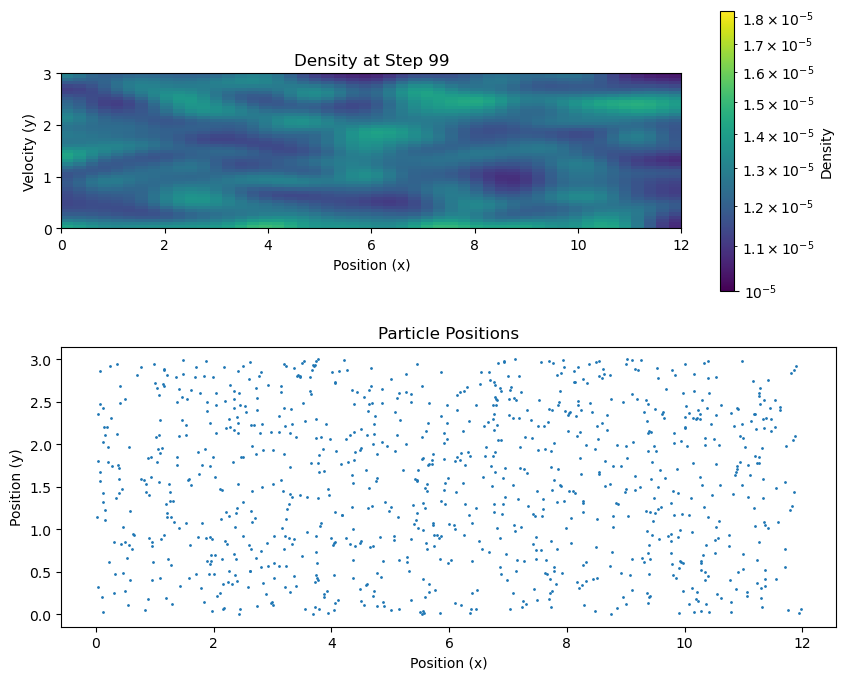

In [34]:
run_simulation_2d(method="front", integration_method="leapfrog",boundary_type = "periodic",gif_name = "shockfront_leap_periodic.gif")

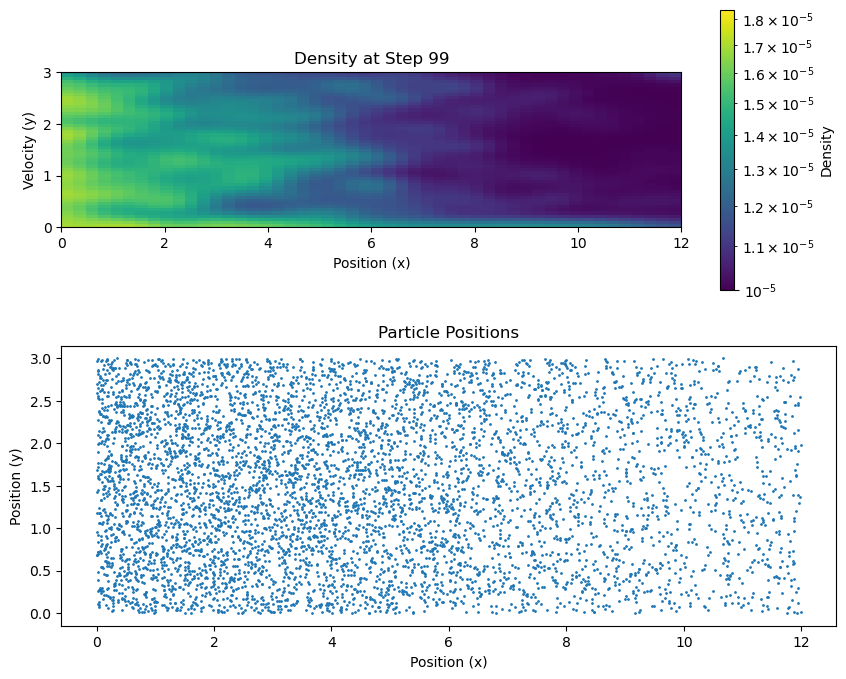

In [38]:
'''
Other example usages:
'''
run_simulation_2d(method="block", integration_method="leapfrog",boundary_type = "reflective",gif_name = "shockblock_leap_reflective.gif")

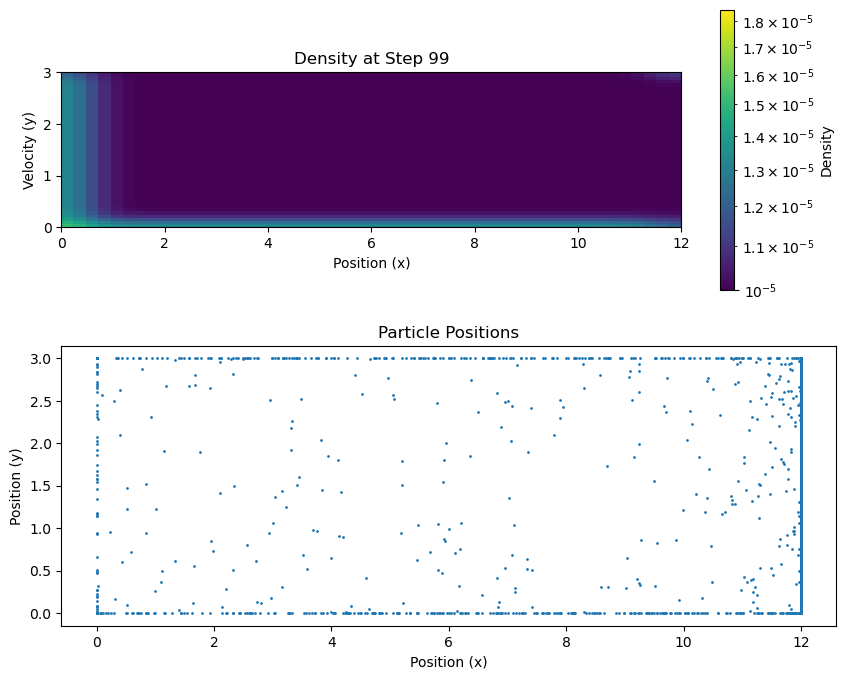

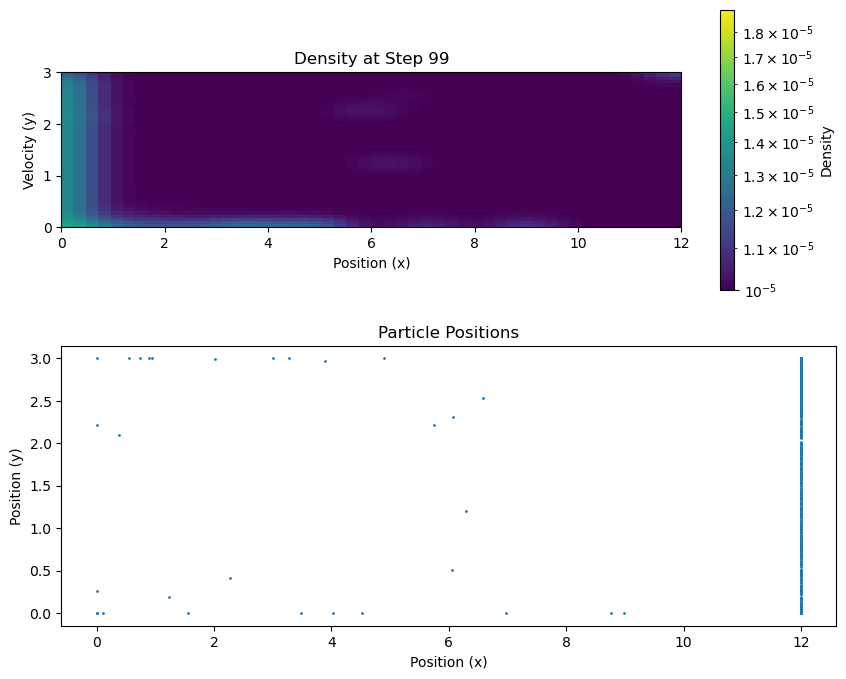

In [40]:
'''
The one downside to the code, is having to change the number of particles in the large code block itself which can be daunting but
you will always have to re run the code block with all the function for the 2d simulation after changing the any intialization parameters
for either the initial set or for the block or front. I figured at least this way though users can see how their changing parameters
affects the simulation, instead of having to type a long list of parameters to the run_simulation_functions. 
'''

run_simulation_2d(method="block", integration_method="leapfrog",boundary_type = "sticky",gif_name = "shockblock_leap_sticky.gif")
run_simulation_2d(method="front", integration_method="leapfrog",boundary_type = "sticky",gif_name = "shockfront_leap_sticky.gif")

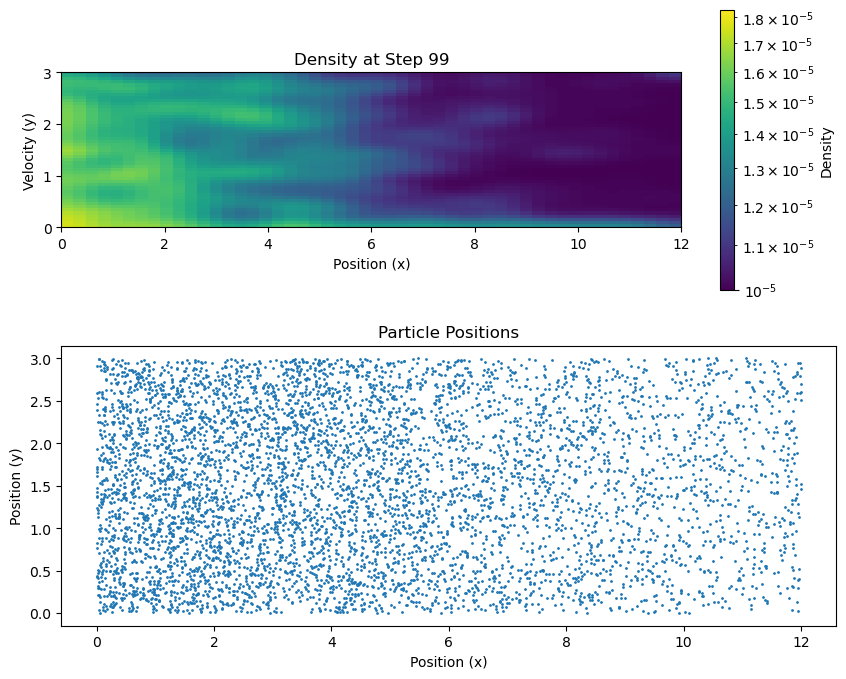

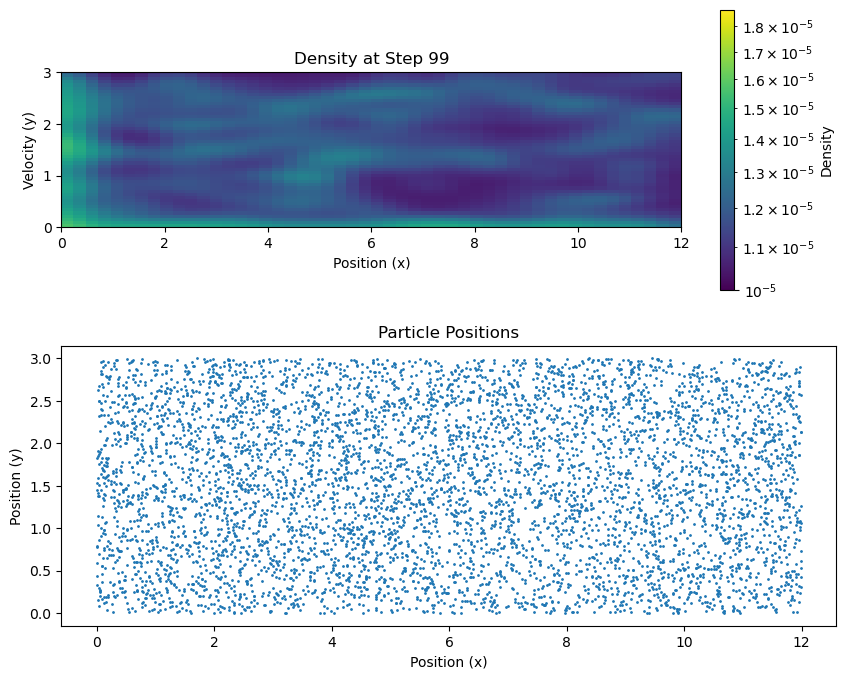

In [56]:
'''
Now maybe let's try out the runge-kutta. This method generally takes a bit longer.
'''
run_simulation_2d(method="block", integration_method="runge_kutta",boundary_type = "reflective",gif_name = "shockblock_rk_reflective.gif")
run_simulation_2d(method="block", integration_method="runge_kutta",boundary_type = "periodic",gif_name = "shockblock_rk_periodic.gif")